<a href="https://colab.research.google.com/gist/EdwinTSalcedo/a2b81fd409bc606864103198c2d40122/region-based-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Region-based Segmentation**

## 1. Watershed Segmentation

The main purpose of the watershed method is to find boundaries between regions, namely "catchment basins". According to this method, any image can be seen as a topology with uniform regions as basins and high intesity sections as peaks. Then, the method proposes to fill in the basins iteratively, so that we can find boundaries that interesect between two or more basins. 

Segmentation using the watershed transform works better if you can identify "marks", which can be seen as initial coordinates to star segmenting. Marker-controlled watershed segmentation follows this basic procedure:

- Convert the image to grayscale.

- Compute a binarized image. This is an image whose white regions are the objects you are trying to segment.

- Compute foreground markers. These are connected blobs of pixels within each of the objects.

- Modify the binarized image so that it only has minima at the foreground marker locations.

- Compute the watershed method of the original image.


Text(0.5, 1.0, 'Overlay with Winter colormap')

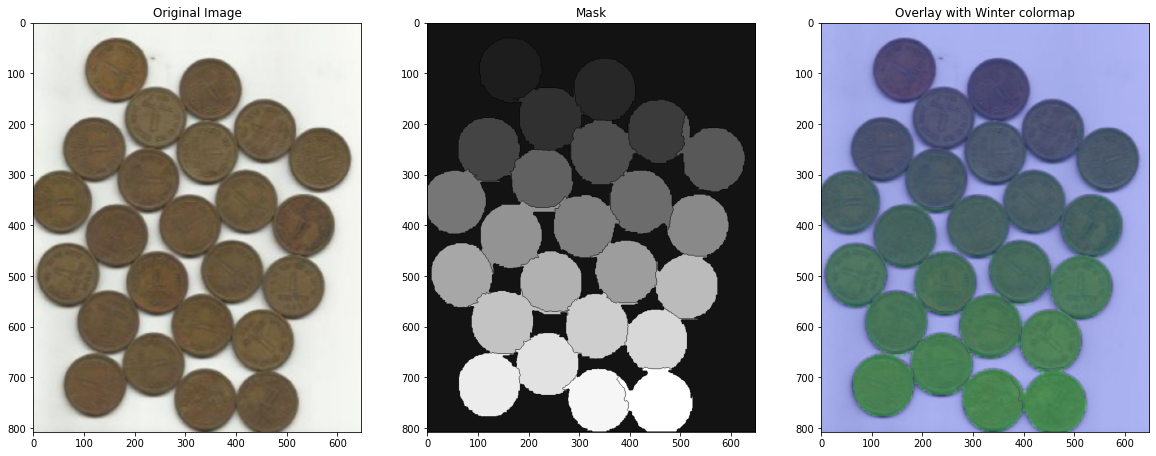

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Import the image
image = cv2.imread("coins.png") 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
base_image = np.copy(image)
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Obtain the binarized version of the image
ret, thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Noise removal with Opening
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Find background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Find foreground area
# the value of each pixel is replaced by its distance to the nearest background pixel
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5) 
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# Apply Watershed Segmentation
markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]

#show the images
plt.rcParams["figure.figsize"] = (20,10)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(base_image)
ax0.set_title("Original Image")
ax1.imshow(markers, cmap = "gray")
ax1.set_title("Mask")
ax2.imshow(base_image)
ax2.imshow(markers, cmap = "winter",alpha=0.3)
ax2.set_title("Overlay with Winter colormap")

## 2. Region Growing 

Similar to Watershed Segmentation, Region Growing is a method oriented to leverage intrinsic regions in an image. The purpose of the method is to merge the points that are close enough in terms of the intensity similarity. Therefore, the output of this algorithm is a set of clusters, where each cluster is a set of points that are considered to be a part of the same component/smooth region. 

The algorithm mainly requires a set of seeds, which will help initialise the regions. Then, for every seed point, the algorithm will evaluate its neighbouring points and join them to the seed's group, if the pixels are similar in terms of intensity. Region Growing is applicable in OpenCV using the `cv2.floodFill` function. This function accepts the following parameters: 

`cv2.floodFill(image, mask, seed_point, new_val, lo_diff, up_diff, flags)`

Where: 

- **image:** An RGB or greyscale image 

- **mask:** Binary image, 2 pixels larger vertivally and horizontally than the original image. This parameter can be left as None if no mask is going to be provided.

- **seed_point:** Starting point to apply the algorithm. There can be several seed points.

- **new_val:** New color that will be applied to all pixels connected to the seed points.

- **lo_diff:** Maximal lower brightness/color difference between the currently observed pixel and one of its neighbors belonging to the component, or a seed pixel being added to the component.

- **up_diff:** Maximal upper brightness/color difference between the currently observed pixel and one of its neighbors belonging to the component, or a seed pixel being added to the component.

- **flags:** Defines the neighbourhood that will be evaluated to extend the region. The default value of 4 means that only the four nearest neighbor pixels (those that share an edge (vertical or horizontal)) are considered. A connectivity value of 8 means that the eight nearest neighbor pixels (those that share a corner) will be considered. 

You can review more details [here](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html?highlight=floodfill#floodfill:~:text=floodFill-,%C2%B6,-Fills%20a%20connected). 

Text(0.5, 1.0, 'Final Result')

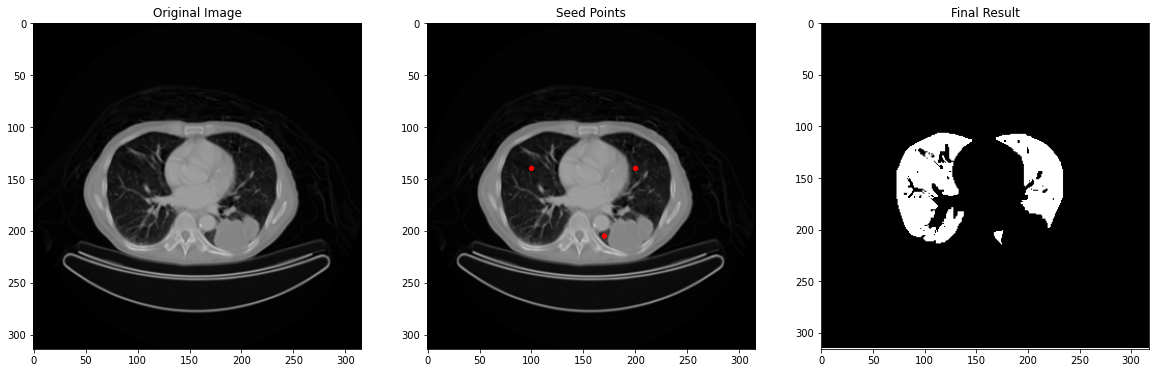

In [26]:
# Read in the image
image = cv2.imread("ct.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create copies to update and show later
image_copy = np.copy(image)
image_copy2 = np.copy(image)

# Create a mask. Notice how we're adding 2 pixels to the right and the bottom
mask = np.zeros((image.shape[0]+2,image.shape[1]+2), np.uint8)

# Create a tuple with the seeds. These must be defined manually, but you might 
# investigate how to find them automatically
seed_points = ((100, 140), (200, 140),(170, 205))
# The colour variance defines how much can be the lo_diff and up_diff parameters
# You can think of this tuple as the threshold to be used in the RGB channels
colour_variance_threshold = (8, 8, 8)

# Apply floodFill with all seed points. Before, draw the seed points in a copy image
for seed_point in seed_points:
  cv2.circle(image_copy, seed_point, 1, (255,0,0), 2)
  cv2.floodFill(image_copy2, mask, seed_point, (255,255,255), colour_variance_threshold, colour_variance_threshold)

# Show the results
plt.rcParams["figure.figsize"] = (20,10)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(image)
ax0.set_title("Original Image")
ax1.imshow(image_copy)
ax1.set_title("Seed Points")
ax2.imshow(mask, cmap="gray")
ax2.set_title("Final Result")